In [1]:
import ast
import os
os.chdir(os.pardir)

import numpy as np
import pandas as pd
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from tqdm.auto import tqdm

from src import load_point_cloud
from src import show_point_cloud
from src import rms_angle_error

from estimator import NormalEstimator

# Baseline

In [2]:
xyz, n = load_point_cloud('Cup33100k_ddist_minmax')

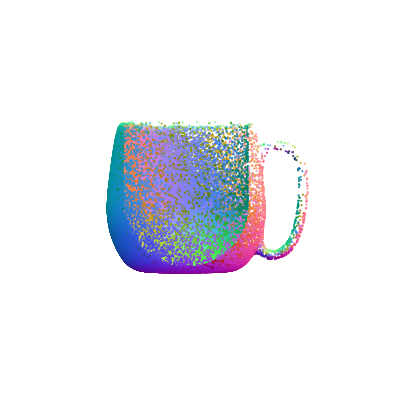

In [3]:
_, ax = show_point_cloud(xyz, n)

In [4]:
k = 30
s = k - np.sqrt(2 * k)
s

22.254033307585168

In [5]:
estimator = NormalEstimator(k=k, deg=3, s=s, kernel=None, gamma=None)

In [6]:
estimator = estimator.fit(xyz)

In [7]:
n_estim = estimator.predict(xyz)

In [8]:
angle_err = rms_angle_error(estimator.predict(xyz), n, orient=False)
print(f'Unoriented normal angle error = {angle_err:.4f}°')

Unoriented normal angle error = 4.6704°


# Hyperparameter tuning

Training set only (validation is not possible in this case).
Validation set will be omitted.

In [9]:
data_path = 'data'

In [10]:
with open(os.path.join(data_path, 'trainingset_no_noise.txt')) as f:
    trainingset_no_noise = [line.strip() for line in f]
with open(os.path.join(data_path, 'trainingset_vardensity_whitenoise.txt')) as f:
    trainingset_vardensity_whitenoise = [line.strip() for line in f]
with open(os.path.join(data_path, 'trainingset_vardensity.txt')) as f:
    trainingset_vardensity = [line.strip() for line in f]
with open(os.path.join(data_path, 'trainingset_whitenoise.txt')) as f:
    trainingset_whitenoise = [line.strip() for line in f]

In [11]:
trainingset_all = (trainingset_no_noise
                   + trainingset_vardensity_whitenoise
                   + trainingset_vardensity
                   + trainingset_whitenoise)

In [12]:
X_train_d = {}
y_train_d = {}
for trainingset in set(trainingset_all):
    xyz, n = load_point_cloud(trainingset)
    X_train_d[trainingset] = xyz
    y_train_d[trainingset] = n

In [13]:
param_grid = [{'k': [10, 30],
               'deg': [2, 3],
               's': [None],
               'kernel': [None]},
              {'k': [30, 50, 100],
               's': [None], 
               'kernel': ['gaussian', 'inverse_multiquadric'],
               'gamma': [0.1, 0.3, 1]},
              {'k': [30, 50, 100],
               's': [None, 10, 0], 
               'kernel': ['rbf'],
               'gamma': [1, 3, 10]}]

In [14]:
scorer = lambda y, y_pred: rms_angle_error(y_pred, y, orient=False)
custom_scorer = make_scorer(scorer, greater_is_better=False)

In [15]:
def tuning():
    df_grid_res = pd.DataFrame()
    for key in tqdm(X_train_d.keys()):
        grid = GridSearchCV(estimator=NormalEstimator(),
                            param_grid=param_grid,
                            scoring=custom_scorer,
                            n_jobs=-1,
                            cv=[(slice(None), slice(None))],
                            verbose=2)
        grid.fit(X_train_d[key], y_train_d[key])
        df_temp = pd.DataFrame(grid.cv_results_)
        df_temp['dataset'] = key
        df_grid_res = pd.concat((df_grid_res, df_temp), ignore_index=True)
        return df_grid_res

In [16]:
force_train = False
save = False
fname = os.path.join('estimator', 'grid_res.csv')

if force_train:
    print('Optimization started...')
    df_grid_res = tuning()
else:
    try:
        print('Trying to restore the grid...')
        df_grid_res = pd.read_csv(fname, index_col=0)
        # df_grid_res['params'] = df_grid_res['params'].apply(
        #     lambda row: ast.literal_eval(row)
        # )
        print('Restoring successful.')
    except Exception as e:
        print(e)
        print('Restoring failed. Fitting the surrogate model...')
        df_grid_res = tuning()
if save:
    df_grid_res.to_csv(fname)

Trying to restore the grid...
Restoring successful.


## Optimal parameters

In [17]:
sel = ['params', 'mean_test_score', 'dataset']

In [18]:
rank_test_score = 1  # best performing
df_grid_res.loc[
    df_grid_res['rank_test_score'] == rank_test_score, sel
].sort_values(by='dataset')

,params,mean_test_score,dataset
1731,"{'gamma': 1, 'k': 30, 'kernel': 'gaussian', 's...",-3.085359,Cup33100k
2010,"{'deg': 2, 'k': 30, 'kernel': None, 's': None}",-3.210115,Cup33100k_ddist_minmax
1927,"{'gamma': 1, 'k': 30, 'kernel': 'gaussian', 's...",-3.075120,Cup33100k_ddist_minmax_layers
706,"{'gamma': 1, 'k': 100, 'kernel': 'gaussian', '...",-23.481510,Cup33100k_noise_white_1.00e-01
1324,"{'deg': 2, 'k': 30, 'kernel': None, 's': None}",-5.522928,Cup33100k_noise_white_1.00e-02
1588,"{'gamma': 1, 'k': 100, 'kernel': 'gaussian', '...",-14.867848,Cup33100k_noise_white_5.00e-02
1878,"{'gamma': 1, 'k': 30, 'kernel': 'gaussian', 's...",-5.604743,armadillo100k
416,"{'gamma': 1, 'k': 30, 'kernel': 'rbf', 's': 0}",-6.159726,armadillo100k_ddist_minmax
415,"{'gamma': 1, 'k': 30, 'kernel': 'rbf', 's': 10}",-6.159726,armadillo100k_ddist_minmax
414,"{'gamma': 1, 'k': 30, 'kernel': 'rbf', 's': None}",-6.159726,armadillo100k_ddist_minmax


In [19]:
no_noise, low_noise, med_noise, high_noise = [], [], [], []
for set in trainingset_whitenoise:
    ind = set.split('_')[-1]
    if ind == '1.00e-02':
        low_noise.append(set)
    elif ind == '5.00e-02':
        med_noise.append(set)
    elif ind == '1.00e-01':
        high_noise.append(set)
    else:
        no_noise.append(set)

In [20]:
trainingset_vardensity
striped, gradient = [], []
for set in trainingset_vardensity:
    ind = set.split('_')[-1]
    if ind == 'layers':
        striped.append(set)
    elif ind == 'minmax':
        gradient.append(set)

In [21]:
def mapper(row):
    if row['dataset'] in no_noise:
        return 'no_noise'
    elif row['dataset'] in low_noise:
        return 'low_noise'
    elif row['dataset'] in med_noise:
        return 'med_noise'
    elif row['dataset'] in high_noise:
        return 'high_noise'
    elif row['dataset'] in striped:
        return 'striped'
    elif row['dataset'] in gradient:
        return 'gradient'
df_grid_res['class'] = df_grid_res[sel].apply(mapper, axis=1)

In [22]:
# grouping params and "class"; for each params-class combo, find the mean RMS
# angle error for all availabe datasets within that class
df_grouped = df_grid_res[['params', 'class', 'mean_test_score']].groupby(
    by=['params', 'class']
).mean().reset_index()
df_grouped

,params,class,mean_test_score
0,"{'deg': 2, 'k': 10, 'kernel': None, 's': None}",gradient,-8.000463
1,"{'deg': 2, 'k': 10, 'kernel': None, 's': None}",high_noise,-46.985365
2,"{'deg': 2, 'k': 10, 'kernel': None, 's': None}",low_noise,-44.008561
3,"{'deg': 2, 'k': 10, 'kernel': None, 's': None}",med_noise,-46.824841
4,"{'deg': 2, 'k': 10, 'kernel': None, 's': None}",no_noise,-8.740605
...,...,...,...
289,"{'gamma': 3, 'k': 50, 'kernel': 'rbf', 's': None}",high_noise,-40.690618
290,"{'gamma': 3, 'k': 50, 'kernel': 'rbf', 's': None}",low_noise,-14.568285
291,"{'gamma': 3, 'k': 50, 'kernel': 'rbf', 's': None}",med_noise,-33.894450
292,"{'gamma': 3, 'k': 50, 'kernel': 'rbf', 's': None}",no_noise,-7.596345


In [23]:
# params with the mean RMS angle error closest to zero (highest in this case)
# should be extracted for test set
idx_max = df_grouped.groupby('class')['mean_test_score'].idxmax()
df_param_opt = df_grouped.loc[idx_max][['class', 'params', 'mean_test_score']]
df_param_opt

,class,params,mean_test_score
138,gradient,"{'gamma': 1, 'k': 30, 'kernel': 'rbf', 's': 0}",-6.450299
103,high_noise,"{'gamma': 1, 'k': 100, 'kernel': 'inverse_mult...",-34.935803
104,low_noise,"{'gamma': 1, 'k': 100, 'kernel': 'inverse_mult...",-11.715842
255,med_noise,"{'gamma': 3, 'k': 100, 'kernel': 'rbf', 's': N...",-25.449993
130,no_noise,"{'gamma': 1, 'k': 30, 'kernel': 'gaussian', 's...",-6.485461
131,striped,"{'gamma': 1, 'k': 30, 'kernel': 'gaussian', 's...",-6.414900


In [24]:
save = False
fname = os.path.join('estimator', 'param_opt.csv')

if save:
    df_param_opt.to_csv(fname)